# CopulaGAN


CopulaGAN is a GAN-based synthetic data generator for tabular data that uses copulas to better model dependencies between features.

GAN component: Learns the overall data distribution and generates synthetic samples.

Copula component: Models dependence structure between columns, especially useful for non-Gaussian or skewed distributions.

In [1]:
import pandas as pd, numpy as np, warnings
warnings.filterwarnings('ignore')
cancer_data = pd.read_csv('data.csv')

cancer_data.drop(['id', 'Unnamed: 32'], axis=1, inplace = True)
cancer_data.replace({'diagnosis':{'M':1, 'B':0}}, inplace=True)

import sdv
from sdv.metadata import SingleTableMetadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(cancer_data)

from sdv.single_table import CopulaGANSynthesizer
copulagan= CopulaGANSynthesizer(metadata)
copulagan.fit(cancer_data)
synthetic_data_copulagan = copulagan.sample(1000)

In [2]:
# diagnostic check and quality check

from sdv.evaluation.single_table import evaluate_quality, run_diagnostic

diagnostic_report = run_diagnostic(cancer_data, synthetic_data_copulagan, metadata) 
quality_report = evaluate_quality(cancer_data, synthetic_data_copulagan, metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 31/31 [00:00<00:00, 1644.45it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 332.49it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 31/31 [00:00<00:00, 624.12it/s]|
Column Shapes Score: 73.42%

(2/2) Evaluating Column Pair Trends: |██████████| 465/465 [00:01<00:00, 370.16it/s]|
Column Pair Trends Score: 79.0%

Overall Score (Average): 76.21%



## Kolmogrov-simrov (KS) test (Max CDF difference between real/synthetic)

In [3]:
from sdv.evaluation.single_table import QualityReport

# 1. Initialize report
quality_report = QualityReport()

# 2. Generate with metadata converted to dict
quality_report.generate(
    real_data=cancer_data,
    synthetic_data=synthetic_data_copulagan,
    metadata=metadata.to_dict()  
)

# 3. Get details
details = quality_report.get_details('Column Shapes')
print(details)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 31/31 [00:00<00:00, 554.13it/s]|
Column Shapes Score: 73.42%

(2/2) Evaluating Column Pair Trends: |██████████| 465/465 [00:01<00:00, 394.38it/s]|
Column Pair Trends Score: 79.0%

Overall Score (Average): 76.21%

                     Column        Metric     Score
0                 diagnosis  TVComplement  0.888583
1               radius_mean  KSComplement  0.578355
2              texture_mean  KSComplement  0.625777
3            perimeter_mean  KSComplement  0.538315
4                 area_mean  KSComplement  0.761232
5           smoothness_mean  KSComplement  0.677504
6          compactness_mean  KSComplement  0.859169
7            concavity_mean  KSComplement  0.808355
8       concave points_mean  KSComplement  0.876364
9             symmetry_mean  KSComplement  0.848777
10   fractal_dimension_mean  KSComplement  0.794172
11                radius_se  KSComplement  0.611415
12               texture_se  KSComplement  

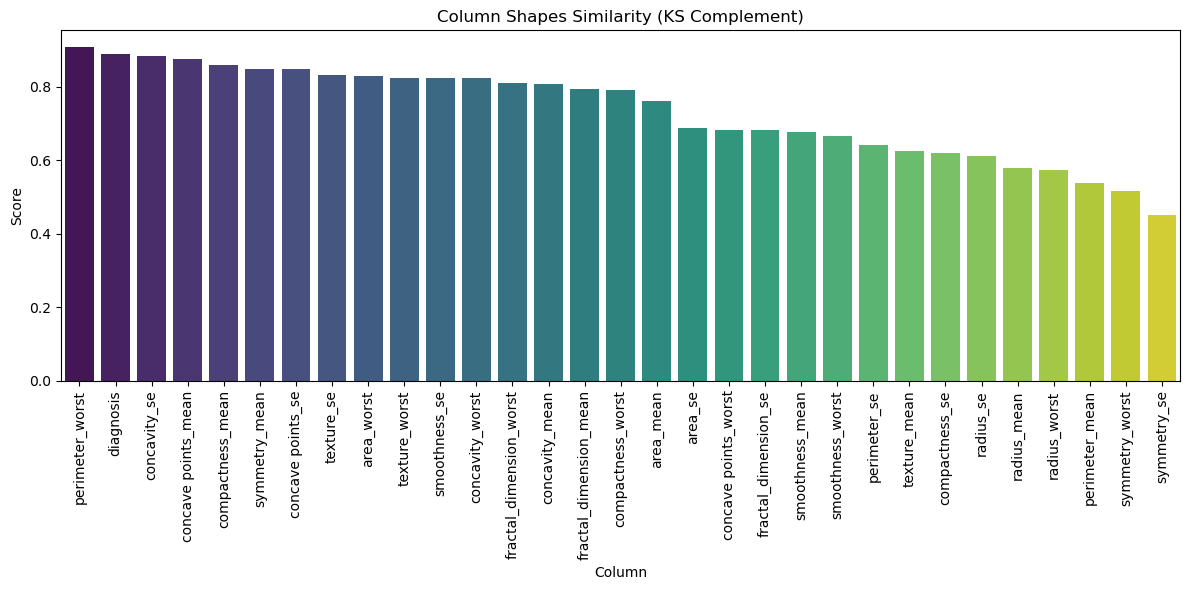

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(
    x='Column', y='Score',
    data=details.sort_values('Score', ascending=False),
    palette='viridis'
)
plt.title('Column Shapes Similarity (KS Complement)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Jensenshannon Distance (Distribution similarity measure)

In [5]:
from pandas.api.types import is_numeric_dtype
from scipy.spatial.distance import jensenshannon
from sklearn.preprocessing import MinMaxScaler

def _prob_vectors_numeric(real, synth, bins=30, eps=1e-12):
    """Convert numeric columns into comparable probability vectors."""
    real = pd.to_numeric(real, errors='coerce').dropna().to_numpy()
    synth = pd.to_numeric(synth, errors='coerce').dropna().to_numpy()

    edges = np.histogram_bin_edges(np.concatenate([real, synth]), bins=bins)
    r_hist, _ = np.histogram(real, bins=edges)
    s_hist, _ = np.histogram(synth, bins=edges)

    r = r_hist.astype(float) + eps
    s = s_hist.astype(float) + eps
    r /= r.sum()
    s /= s.sum()
    return r, s

def _prob_vectors_categorical(real, synth, eps=1e-12):
    """Convert categorical columns into comparable probability vectors."""
    r_counts = real.astype(str).value_counts(dropna=False)
    s_counts = synth.astype(str).value_counts(dropna=False)
    keys = r_counts.index.union(s_counts.index)
    r = r_counts.reindex(keys, fill_value=0).to_numpy(dtype=float) + eps
    s = s_counts.reindex(keys, fill_value=0).to_numpy(dtype=float) + eps
    r /= r.sum()
    s /= s.sum()
    return r, s, keys
    

In [6]:
# ---------- Main function ----------
def compute_js_divergence(real_df: pd.DataFrame,
                          synth_df: pd.DataFrame,
                          bins=30,
                          normalize=True) -> pd.DataFrame:
    """
    Compute Jensen–Shannon Divergence for each column between real and synthetic data.
    Returns a DataFrame with per-feature JS divergence values.
    """

    common_cols = [c for c in real_df.columns if c in synth_df.columns]
    real = real_df[common_cols].copy()
    synth = synth_df[common_cols].copy()

    # Optional normalization for numeric columns
    if normalize:
        num_cols = [c for c in common_cols if is_numeric_dtype(real[c])]
        scaler = MinMaxScaler()
        real[num_cols] = scaler.fit_transform(real[num_cols])
        synth[num_cols] = scaler.transform(synth[num_cols])

    results = []
    for col in common_cols:
        r_col, s_col = real[col], synth[col]

        if is_numeric_dtype(r_col):
            p, q = _prob_vectors_numeric(r_col, s_col, bins=bins)
        else:
            p, q, _ = _prob_vectors_categorical(r_col, s_col)

        # Jensen-Shannon divergence (base=2 → bounded [0,1])
        js_div = jensenshannon(p, q, base=2) ** 2

        results.append({"Feature": col, "JS_Divergence": js_div})

    return pd.DataFrame(results).sort_values("JS_Divergence")

In [7]:
results = compute_js_divergence(cancer_data, synthetic_data_copulagan, bins="fd", normalize=True)
print(results)

                    Feature  JS_Divergence
0                 diagnosis       0.009164
17             concavity_se       0.034109
6          compactness_mean       0.034434
27          concavity_worst       0.038319
12               texture_se       0.043290
9             symmetry_mean       0.044386
7            concavity_mean       0.048705
23          perimeter_worst       0.050639
26        compactness_worst       0.054112
30  fractal_dimension_worst       0.059322
8       concave points_mean       0.061301
22            texture_worst       0.064098
24               area_worst       0.064194
15            smoothness_se       0.068293
10   fractal_dimension_mean       0.071244
4                 area_mean       0.072712
18        concave points_se       0.092136
20     fractal_dimension_se       0.110318
28     concave points_worst       0.123650
25         smoothness_worst       0.123997
14                  area_se       0.126526
5           smoothness_mean       0.129689
2          

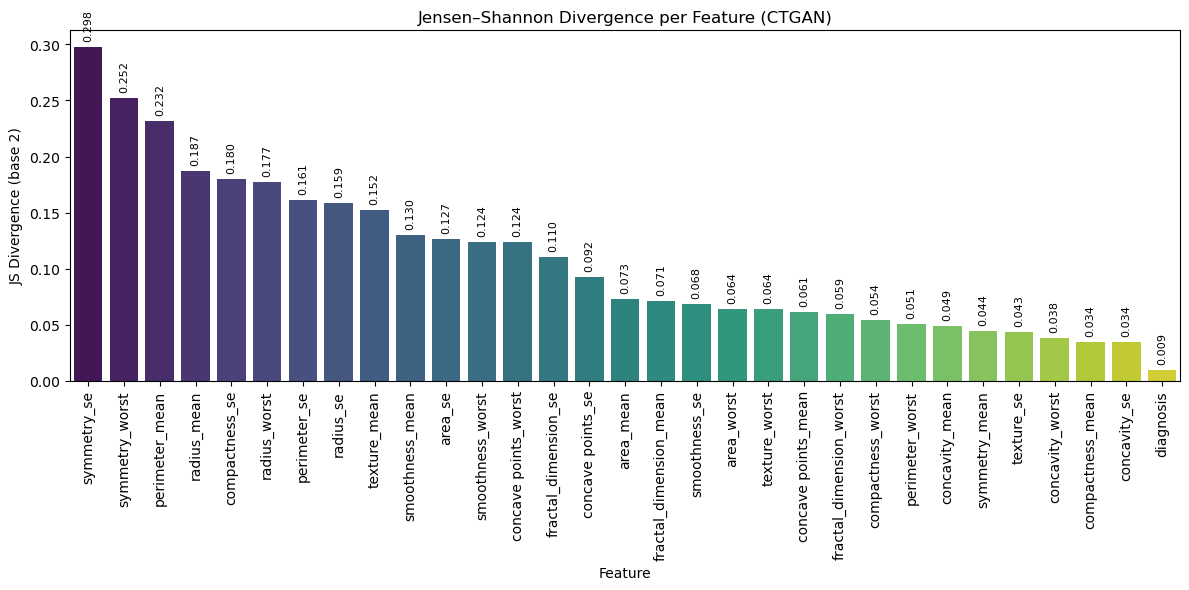

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute JS divergence
results = compute_js_divergence(cancer_data, synthetic_data_copulagan, bins="fd", normalize=True)

# Sort for better readability
results = results.sort_values("JS_Divergence", ascending=False)

# Create bar chart
plt.figure(figsize=(12,6))
bars = sns.barplot(x="Feature", y="JS_Divergence", data=results, palette="viridis")

# Add value labels on each bar
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        yval + 0.005,                    # vertical offset
        f"{yval:.3f}",                   # formatted value
        ha="center", va="bottom", fontsize=8, rotation=90
    )

# Aesthetics
plt.xticks(rotation=90)
plt.ylabel("JS Divergence (base 2)")
plt.title("Jensen–Shannon Divergence per Feature (CTGAN)")
plt.tight_layout()
plt.show()

## Wasserstein Distance (Distance between full distributions)

In [9]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import wasserstein_distance
import pandas as pd

# Assume cancer_data (real) and synthetic_data (synthetic) are your DataFrames

# Initialize MinMax scaler
scaler = MinMaxScaler()


# Fit on the real data and transform both
real_scaled = pd.DataFrame(scaler.fit_transform(cancer_data), columns=cancer_data.columns)
synthetic_scaled = pd.DataFrame(scaler.transform(synthetic_data_copulagan), columns=synthetic_data_copulagan.columns)

# Compute normalized Wasserstein distance
for col in cancer_data.columns:
    dist = wasserstein_distance(real_scaled[col], synthetic_scaled[col])
    print(f"{col}: {dist:.4f}")

diagnosis: 0.1114
radius_mean: 0.1341
texture_mean: 0.1059
perimeter_mean: 0.2478
area_mean: 0.0466
smoothness_mean: 0.1024
compactness_mean: 0.0534
concavity_mean: 0.0396
concave points_mean: 0.0711
symmetry_mean: 0.0384
fractal_dimension_mean: 0.0518
radius_se: 0.0531
texture_se: 0.0509
perimeter_se: 0.0333
area_se: 0.0262
smoothness_se: 0.0579
compactness_se: 0.0767
concavity_se: 0.0226
concave points_se: 0.0506
symmetry_se: 0.2554
fractal_dimension_se: 0.0782
radius_worst: 0.1231
texture_worst: 0.0578
perimeter_worst: 0.0589
area_worst: 0.0888
smoothness_worst: 0.1217
compactness_worst: 0.0400
concavity_worst: 0.0654
concave points_worst: 0.2036
symmetry_worst: 0.1051
fractal_dimension_worst: 0.0324


In [10]:
import gower

real_data = cancer_data
synthetic_data = synthetic_data_copulagan

# Remove target column
X_real = real_data.drop(columns=['diagnosis'])
X_synth = synthetic_data.drop(columns=['diagnosis'])

# Compute Gower distance matrices
gower_real = 1 - gower.gower_matrix(X_real)    # similarity = 1 - distance
gower_synth = 1 - gower.gower_matrix(X_synth)
gower_cross = 1 - gower.gower_matrix(X_real, X_synth)  # cross-set similarity


# Upper triangle indices (exclude diagonal)

real_upper = gower_real[np.triu_indices_from(gower_real, k=1)]
synth_upper = gower_synth[np.triu_indices_from(gower_synth, k=1)]

# Max and average intra-set similarity

max_intra_real = np.max(real_upper)
avg_intra_real = np.mean(real_upper)

max_intra_synth = np.max(synth_upper)
avg_intra_synth = np.mean(synth_upper)

# Flatten the cross-set matrix

cross_flat = gower_cross.flatten()

max_cross = np.max(cross_flat)
avg_cross = np.mean(cross_flat)


print("Intra-set Similarity (Real):")
print(f"Max = {max_intra_real:.4f}, Avg = {avg_intra_real:.4f}\n")

print("Intra-set Similarity (Synthetic):")
print(f"Max = {max_intra_synth:.4f}, Avg = {avg_intra_synth:.4f}\n")

print("Cross-set Similarity (Real vs Synthetic):")
print(f"Max = {max_cross:.4f}, Avg = {avg_cross:.4f}")

Intra-set Similarity (Real):
Max = 0.9809, Avg = 0.8528

Intra-set Similarity (Synthetic):
Max = 0.9258, Avg = 0.8025

Cross-set Similarity (Real vs Synthetic):
Max = 0.9294, Avg = 0.8161


### t-SNE = Local Fidelity / Distribution Visualization Metric

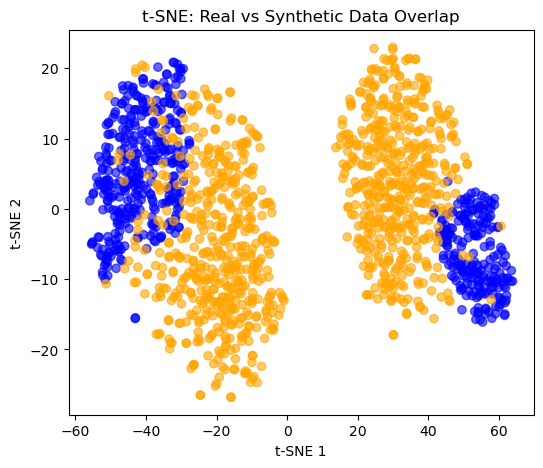

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
combined = np.vstack([real_scaled, synthetic_scaled])
tsne_result = tsne.fit_transform(combined)
labels = ['Real'] * len(real_scaled) + ['Synthetic'] * len(synthetic_scaled)

plt.figure(figsize=(6,5))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1],
            c=['blue' if l == 'Real' else 'orange' for l in labels],
            alpha=0.6, label=None)
plt.title("t-SNE: Real vs Synthetic Data Overlap")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

# Distributional similarity metrics

##### MMD — Maximum Mean Discrepancy (statistical distance that measures the difference between the distributions of two datasets)

In [12]:
from sklearn.preprocessing import StandardScaler    
from scipy.stats import wasserstein_distance

scaler = StandardScaler()
real_scaled = scaler.fit_transform(cancer_data.drop(columns=['diagnosis']))
synthetic_scaled = scaler.transform(synthetic_data_copulagan.drop(columns=['diagnosis']))

# MMD (using Gaussian kernel)
def gaussian_kernel(x, y, sigma=1.0):
    x_size = x.shape[0]
    y_size = y.shape[0]
    dim = x.shape[1]
    x_tile = np.tile(x, (y_size, 1))
    y_tile = np.repeat(y, x_size, axis=0)
    return np.exp(-np.sum((x_tile - y_tile)**2, axis=1) / (2 * dim * sigma**2)).reshape(y_size, x_size)

def compute_mmd(x, y, sigma=1.0):
    k_xx = np.mean(gaussian_kernel(x, x, sigma))
    k_yy = np.mean(gaussian_kernel(y, y, sigma))
    k_xy = np.mean(gaussian_kernel(x, y, sigma))
    return k_xx + k_yy - 2 * k_xy

mmd_score = compute_mmd(real_scaled, synthetic_scaled)


print(f"MMD score: {mmd_score:.4f}")

MMD score: 0.2011


### Cosine Similarity Metrics

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

# Cosine similarity
cross_sim = cosine_similarity(real_scaled, synthetic_scaled)
avg_sim = np.mean(cross_sim)
max_sim = np.max(cross_sim)


print(f"\n ----- Sample-Level Similarity--------- \n")

print(f"Average cosine similarity: {avg_sim:.4f}")
print(f"Maximum cosine similarity: {max_sim:.4f}")


 ----- Sample-Level Similarity--------- 

Average cosine similarity: -0.0064
Maximum cosine similarity: 0.7473


In [15]:
# TSTR (Train on synthetic and test on real data)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Define real and synthetic datasets
real_data = cancer_data
synthetic_data = synthetic_data_copulagan

# -----------------------------
# 1. Train on Synthetic → Test on Real (TSTR)
# -----------------------------

# Split synthetic data (train/test)
X_synth = synthetic_data.drop(['diagnosis'], axis=1)
y_synth = synthetic_data['diagnosis']
X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(
    X_synth, y_synth, test_size=0.2, random_state=42
)

# Split real data (train/test)
X_real = real_data.drop(['diagnosis'], axis=1)
y_real = real_data['diagnosis']
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42
)

# Scale features using scaler fitted on synthetic training data
scaler = StandardScaler().fit(X_train_synth)
X_train_synth_scaled = scaler.transform(X_train_synth)
X_test_real_scaled = scaler.transform(X_test_real)

# Train model on synthetic data
model_tstr = RandomForestClassifier(random_state=42)
model_tstr.fit(X_train_synth_scaled, y_train_synth)

# Test on real data
y_pred_real = model_tstr.predict(X_test_real_scaled)
y_pred_prob_real = model_tstr.predict_proba(X_test_real_scaled)[:, 1]

# Evaluate TSTR performance
acc_tstr = accuracy_score(y_test_real, y_pred_real)
f1_tstr = f1_score(y_test_real, y_pred_real)
auc_tstr = roc_auc_score(y_test_real, y_pred_prob_real)

print("Train on Synthetic, Test on Real (TSTR):")
print(f"Accuracy = {acc_tstr:.3f}")
print(f"F1 Score = {f1_tstr:.3f}")
print(f"AUC = {auc_tstr:.3f}")


# -----------------------------
# 2. Baseline: Train Real → Test Real (TRTR)
# -----------------------------

# Scale real data using scaler fitted on real training set
scaler_real = StandardScaler().fit(X_train_real)
X_train_real_scaled = scaler_real.transform(X_train_real)
X_test_real_scaled_baseline = scaler_real.transform(X_test_real)

# Train on real data
model_baseline = RandomForestClassifier(random_state=42)
model_baseline.fit(X_train_real_scaled, y_train_real)

# Test on real data
y_pred_baseline = model_baseline.predict(X_test_real_scaled_baseline)
y_pred_prob_baseline = model_baseline.predict_proba(X_test_real_scaled_baseline)[:, 1]

# Evaluate baseline model
acc_trtr = accuracy_score(y_test_real, y_pred_baseline)
f1_trtr = f1_score(y_test_real, y_pred_baseline)
auc_trtr = roc_auc_score(y_test_real, y_pred_prob_baseline)

print("\nBaseline: Train on Real, Test on Real (TRTR):")
print(f"Accuracy = {acc_trtr:.3f}")
print(f"F1 Score = {f1_trtr:.3f}")
print(f"AUC = {auc_trtr:.3f}")

Train on Synthetic, Test on Real (TSTR):
Accuracy = 0.746
F1 Score = 0.580
AUC = 0.835

Baseline: Train on Real, Test on Real (TRTR):
Accuracy = 0.965
F1 Score = 0.952
AUC = 0.995


# Privacy

In [16]:
# Privacy (Nearest Neighbor Distance)

from sklearn.neighbors import NearestNeighbors
# Standardize using the same scaler
scaler = StandardScaler()
real_scaled = scaler.fit_transform(cancer_data.drop(columns=['diagnosis']))
synthetic_scaled = scaler.transform(synthetic_data_copulagan.drop(columns=['diagnosis']))

# Compute Nearest Neighbor Distance
nn = NearestNeighbors(n_neighbors=1).fit(real_scaled)
distances, _ = nn.kneighbors(synthetic_scaled)
avg_nn_dist = np.mean(distances)

print("Privacy Check:")
print(f"Average Nearest Neighbor Distance (Synthetic → Real): {avg_nn_dist:.4f}")

Privacy Check:
Average Nearest Neighbor Distance (Synthetic → Real): 7.0952


# Bivariate analysis 

In [18]:
from itertools import combinations
import numpy as np, pandas as pd
from scipy import stats

real_df = cancer_data
synth_df = synthetic_data_copulagan

# Make sure column names match
synth_df = synth_df[real_df.columns]

num_cols = [c for c in real_df.columns if c != "diagnosis"]
cat_cols = ["diagnosis"]

def bivariate_quality_cancer(real_df, synth_df, target = 'diagnosis'):
    num_cols 
    results_corr = []
    results_target = []

    # numeric to numeric 

    for a, b in combinations(num_cols, 2):
        r_corr = real_df[[a,b]].corr().iloc[0,1]
        s_corr = synth_df[[a,b]].corr().iloc[0,1]
        results_corr.append({'var_a':a, 'var_b':b, 'delta_corr': abs(r_corr-s_corr)})
    
    # numeric to target 

    for col in num_cols:
        r_groups = [g[col].values for _, g in real_df.groupby(target)]
        s_groups = [g[col].values for _, g in synth_df.groupby(target)]
        if len(r_groups) == 2:
            d_real = stats.wasserstein_distance(*r_groups)
            d_synth = stats.wasserstein_distance(*s_groups)
            results_target.append({"feature": col, "delta_wasserstein": abs(d_real - d_synth)})

    return(pd.DataFrame(results_corr).sort_values("delta_corr", ascending=False),
           pd.DataFrame(results_target).sort_values("delta_wasserstein", ascending=False))

corr_results, target_results = bivariate_quality_cancer(real_df=cancer_data, synth_df=synthetic_data_copulagan)


# Largest differences in pairwise correlations
print(corr_results.head(10))

# Features that differ most by diagnosis class

print('================================')

print(target_results.head(10))

                var_a            var_b  delta_corr
57     perimeter_mean        area_mean    1.075683
392      radius_worst       area_worst    1.069232
2         radius_mean        area_mean    1.002921
391      radius_worst  perimeter_worst    0.997065
76     perimeter_mean  perimeter_worst    0.983279
178    concavity_mean  concavity_worst    0.980028
22        radius_mean       area_worst    0.969086
135  compactness_mean   concavity_mean    0.967508
21        radius_mean  perimeter_worst    0.965404
103         area_mean       area_worst    0.964099
            feature  delta_wasserstein
3         area_mean         454.855900
23       area_worst         435.956186
13          area_se          47.775544
22  perimeter_worst          43.849288
2    perimeter_mean          34.045656
20     radius_worst           7.027021
21    texture_worst           5.338640
0       radius_mean           4.911790
1      texture_mean           3.241668
12     perimeter_se           2.033180


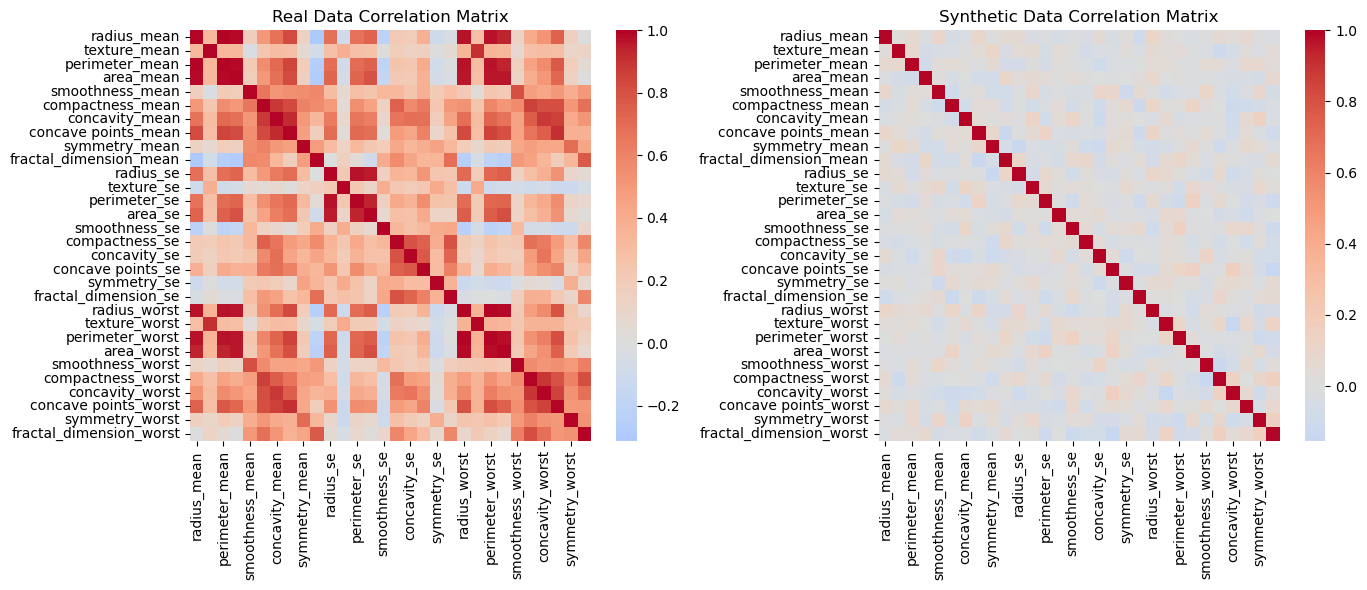

In [19]:
# Compare correlations side by side

# Plotting both correlation metrics as heatmaps 

import matplotlib.pyplot as plt
import seaborn as sns

num_cols = [c for c in real_df.columns if c != "diagnosis"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(real_df[num_cols].corr(), cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("Real Data Correlation Matrix")

sns.heatmap(synth_df[num_cols].corr(), cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("Synthetic Data Correlation Matrix")

plt.tight_layout()
plt.show()

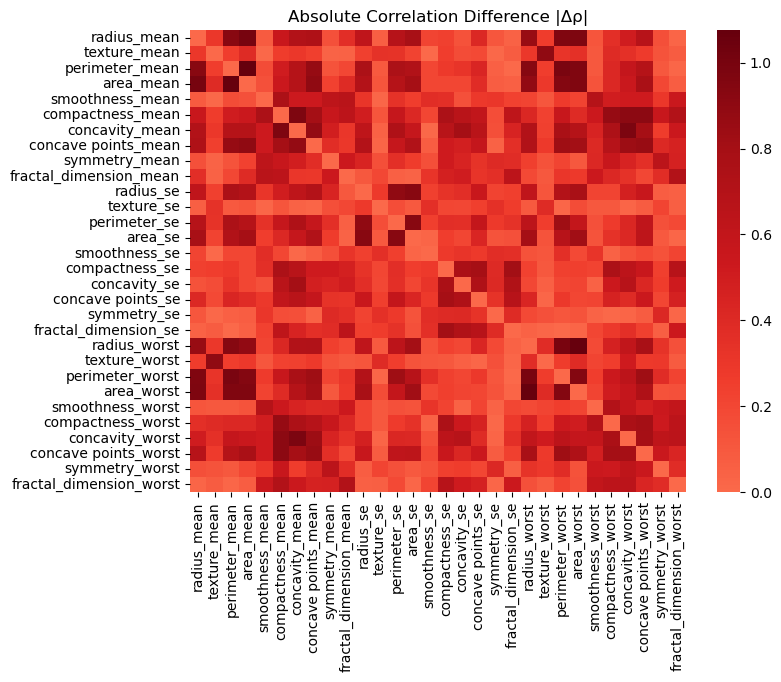

In [20]:
diff_corr = abs(real_df[num_cols].corr() - synth_df[num_cols].corr())
plt.figure(figsize=(8,6))
sns.heatmap(diff_corr, cmap="Reds", center=0)
plt.title("Absolute Correlation Difference |Δρ|")
plt.show()

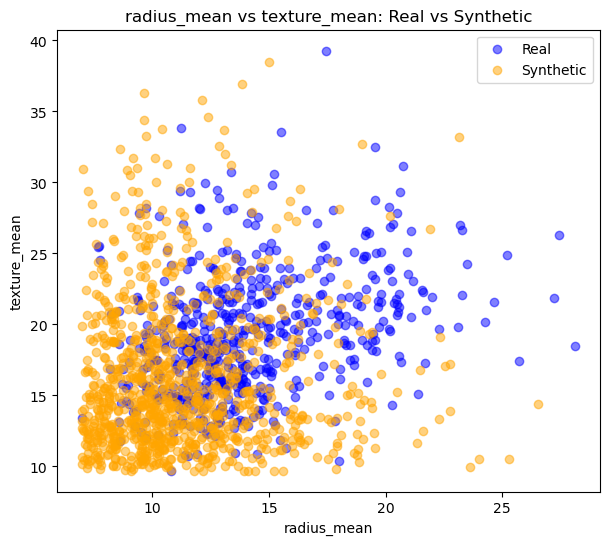

In [21]:
# Overlay 2D scatter (bivariate plot) for selected pair

x = "radius_mean"
y = "texture_mean"

plt.figure(figsize=(7,6))
plt.scatter(real_df[x], real_df[y], alpha=0.5, label="Real", color="blue")
plt.scatter(synth_df[x], synth_df[y], alpha=0.5, label="Synthetic", color="orange")
plt.xlabel(x)
plt.ylabel(y)
plt.legend()
plt.title(f"{x} vs {y}: Real vs Synthetic")
plt.show()

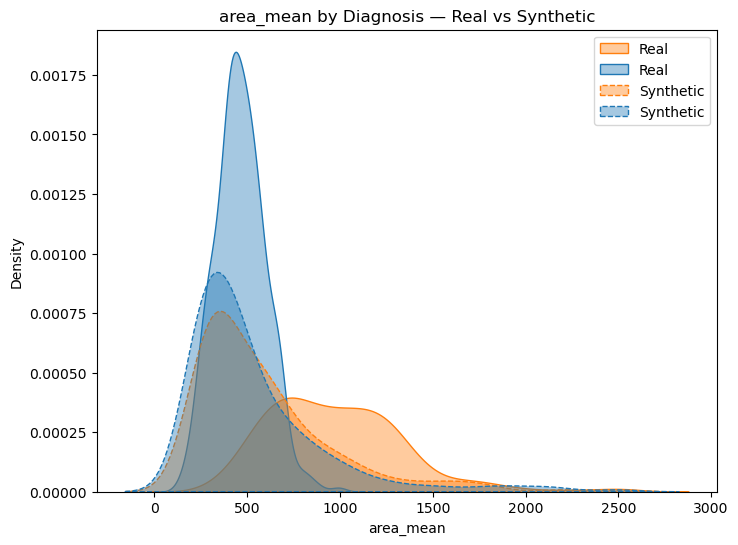

In [22]:
# Compare conditional distributions (numeric ↔ categorical)

import seaborn as sns

feature = "area_mean"

plt.figure(figsize=(8,6))
sns.kdeplot(data=real_df, x=feature, hue="diagnosis", fill=True, alpha=0.4, label="Real")
sns.kdeplot(data=synth_df, x=feature, hue="diagnosis", fill=True, alpha=0.4, linestyle="--", label="Synthetic")
plt.title(f"{feature} by Diagnosis — Real vs Synthetic")
plt.legend()
plt.show()

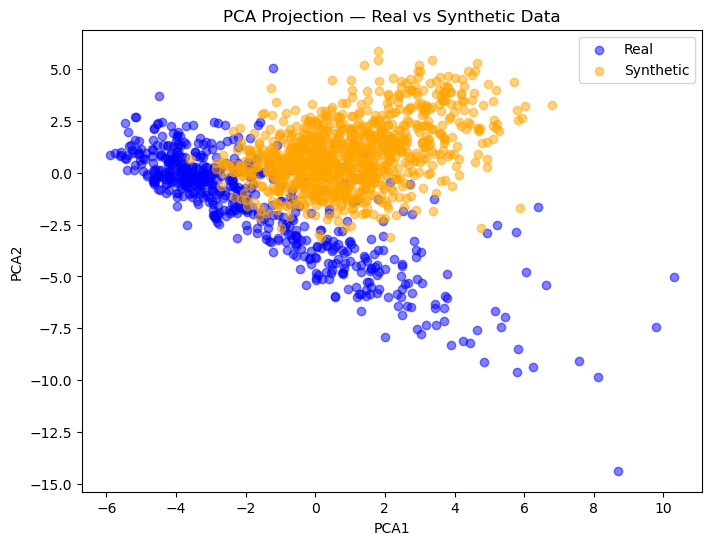

In [23]:
# PCA projection colored by dataset type

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

num_cols = [c for c in real_df.columns if c != "diagnosis"]
scaler = StandardScaler()
X_real = scaler.fit_transform(real_df[num_cols])
X_syn = scaler.transform(synth_df[num_cols])

pca = PCA(n_components=2)
X_all = np.vstack([X_real, X_syn])
pca_all = pca.fit_transform(X_all)

n_real = len(X_real)
labels = np.array(["Real"] * n_real + ["Synthetic"] * len(X_syn))

plt.figure(figsize=(8,6))
plt.scatter(pca_all[labels=="Real",0], pca_all[labels=="Real",1], color="blue", alpha=0.5, label="Real")
plt.scatter(pca_all[labels=="Synthetic",0], pca_all[labels=="Synthetic",1], color="orange", alpha=0.5, label="Synthetic")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("PCA Projection — Real vs Synthetic Data")
plt.legend()
plt.show()

# Multi-variate analysis

In [24]:
# MMD computation (global distribution distance)

from sklearn.metrics.pairwise import rbf_kernel
def mmd_rbf(X, Y, gamma=None):
    if gamma is None:
        Z = np.vstack([X, Y])
        dists = np.sqrt(((Z[:,None,:]-Z[None,:,:])**2).sum(-1))
        med = np.median(dists[dists>0])
        gamma = 1.0 / (2*(med**2))
    Kxx = rbf_kernel(X, X, gamma)
    Kyy = rbf_kernel(Y, Y, gamma)
    Kxy = rbf_kernel(X, Y, gamma)
    n, m = len(X), len(Y)
    return (Kxx.sum() - np.trace(Kxx))/(n*(n-1)) + (Kyy.sum() - np.trace(Kyy))/(m*(m-1)) - 2*Kxy.mean()

mmd_value = mmd_rbf(X_real, X_synth)
print("Global MMD (RBF):", mmd_value)

Global MMD (RBF): 0.6853866686061842


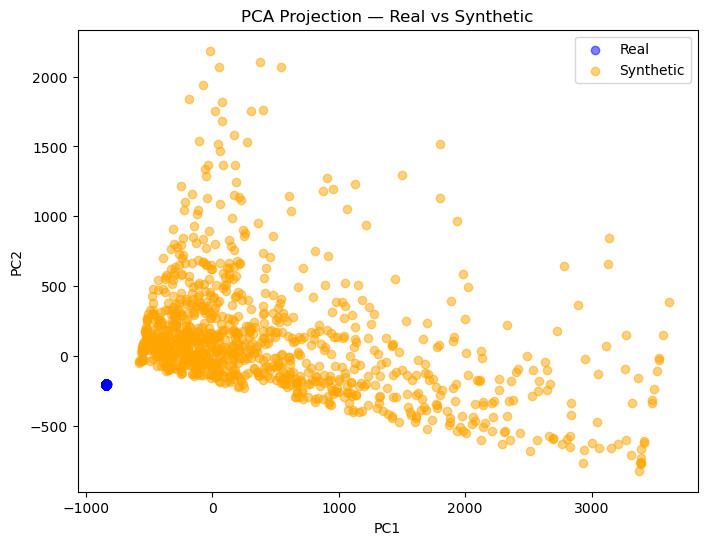

In [25]:
# PCA visualization

import matplotlib.pyplot as plt
pca = PCA(n_components=2)
X_all = np.vstack([X_real, X_synth])
labels = np.array(['Real'] * len(X_real) + ['Synthetic'] * len(X_synth))
X_pca = pca.fit_transform(X_all)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[labels=='Real',0], X_pca[labels=='Real',1], color='blue', alpha=0.5, label='Real')
plt.scatter(X_pca[labels=='Synthetic',0], X_pca[labels=='Synthetic',1], color='orange', alpha=0.5, label='Synthetic')
plt.title("PCA Projection — Real vs Synthetic")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(); plt.show()